![Py4Eng](img/logo.png)

# Convolutional Neural Networks with TensorFlow
## Yoav Ram

In this session we will understand:
- what is TensorFlow
- how to use TensorFlow to construct and train convolutional neural netowrks
- how to use Keras as a high-level API to TensorFlow

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
print('TensorFlow', tf.__version__)
import keras

TensorFlow 1.13.1


Using TensorFlow backend.


# MNIST data

We follow the TensorFlow [Deep MNIST for Experts](https://www.tensorflow.org/versions/r0.7/tutorials/mnist/pros/index.html) tutorial. This tutorial is focused on a classic classification problem: identifying hand-written digits. We already used [scikit-learn](ML.ipynb) to address this problem, so we can compare TensorFlow's performence with scikit-learn's.

We use TensorFlow's supplied script to load the data:

In [2]:
(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()
nsamples, width, height = X_train.shape
nfeatures = width * height
X_train = X_train/255
X_test = X_test/255
X_train = X_train.reshape(nsamples, nfeatures)
X_test = X_test.reshape(-1, nfeatures)
Y_train = keras.utils.to_categorical(Y_train)
Y_test = keras.utils.to_categorical(Y_test)
ncats = Y_test.shape[1]

The images are 1D arrays of length 784; the labels are one-hot encodes numbers between 0 and 9:

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


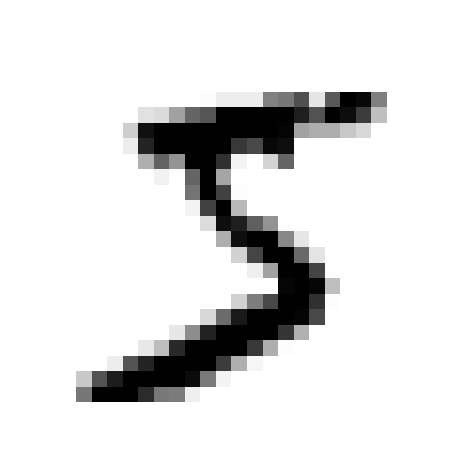

In [3]:
def display_image(im):
    plt.imshow(im, cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
    sns.despine(top=True, right=True, left=True, bottom=True)
    
print(Y_train[0])
display_image(X_train[0].reshape(28, 28))

We start an interactive session:

In [4]:
sess = tf.InteractiveSession()

# Multilayer Convolutional Network

We build a multilayer convolutional neuron network.

This includes applying convolution filters on the images, pooling, and then applying softmax regression in the readout layer.
We also use dropout to reduce over-fitting.

For details on the operations see the [FFN session](FFN.ipynb) and the [CNN session](CNN.ipynb).

**Note** Training this model may take several hours!!

We define a function to create weight and bias variables - we'll use it a lot:

In [5]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

We're going to use simple convolutions (stride of one, zero padding) and pooling (max over 2x2 blocks):

In [6]:
def conv2d(x, W):
    return tf.nn.conv2d(
        x, 
        filter=W, 
        strides=[1, 1, 1, 1], 
        padding='SAME'
    )

def max_pool_2x2(x):
    return tf.nn.max_pool(
        x, 
        ksize=[1, 2, 2, 1],
        strides=[1, 2, 2, 1], 
        padding='SAME'
    )

## First convolutional layer

The first layer has a convolution followed by max pooling.

The convolution computes 32 features of 5x5 patches; given a 4D input tensor of shape `[batch=-1, in_height=28, in_width=28, in_channels=1]` and a 4D filter / kernel tensor of shape `[filter_height=5, filter_width=5, in_channels=1, out_channels=32]`, the convolution:

1. Flattens the filter to a 2-D matrix with shape
   `[filter_height * filter_width * in_channels = 5*5*1, out_channels=32]`.
2. Extracts image patches from the input tensor to form a *virtual*
   tensor of shape `[batch=-1, out_height=28, out_width=28, filter_height * filter_width * in_channels = 5*5*1]`.
3. For each patch, right-multiplies the filter matrix and the image patch
   vector.
   
So the convolution accepts `batches x 28 x 28 x 1` data shape and returns `batches x 28 x 28 x 32`.
   
We then add the bias vector and apply a ReLu activation function ($f(x)=max(0,x)$).

The pooling computes the max of every 2x2 patch, thus reducing the data shape to `batches x 14 x 14 x 32`.

In [7]:
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

In [9]:
x_image = tf.reshape(x, [-1, 28, 28, 1])

W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

## Second convolutional layer

We add another convolution + pooling layer, the 2nd layer will have 64 features. The input has 32 channels (from the previous 32 features) but he data arrays are smaller (14x14) due to the previous pooling:

In [10]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

The data is now is shape `batchesx7x7x64`.

## Fully connected layer

Now we add a fully-connected layer with 1024 neurons. This is done by matrix multiplication with a 7x7x64-by-1024 weight matrix. We add bias, and apply an activation function, as before:

In [11]:
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(h_pool2_flat @ W_fc1 + b_fc1)

## Dropout layer

We apply a dropout to reduce overfitting: the dropout stochasticly removes neurons (outputs of the previous layer) and automatically scales the neurons it retained so that their expected sum remains unchanged. `dropout` accepts a `keep_prob` argument which defines the probability that a neuron is kept. We provide this probability as a `placeholder` to that dropout can be turned on (during training) and off (during testing / predicting).

In [13]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, rate=1-keep_prob)

## Readout layer

We add a Softmax regression layer, similar to the previous, simpler example, including the regression coefficients, bias, and the softmax function:

In [14]:
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv=tf.nn.softmax(h_fc1_drop @ W_fc2 + b_fc2)

## Training

To train the model we need to define the loss function. We'll use the same cross entropy function as before. We also use the same measure for accuracy - we predict the most likelihood class and check that it is the correct label.

We use the [Adam optimizer](http://arxiv.org/pdf/1412.6980.pdf), an algorithm for stochastic gradient descent based on adaptive estimates of first and second moments.

In [15]:
cross_entropy = -tf.reduce_sum(y_ * tf.log(y_conv))
optimizer = tf.train.AdamOptimizer(1e-4)
train_step = optimizer.minimize(cross_entropy)

correct_prediction = tf.argmax(y_conv, 1) == tf.argmax(y_, 1)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Finally, we run the stochastic training by batches.

**Note** this can take several hours. If you just want to see it work, change `n_steps` to a much smaller value. 

In [48]:
sess.run(tf.global_variables_initializer())

n_steps = 20000
for i in range(n_steps):
    start = (i * 50) % X_train.shape[0]
    stop = start + 50
    batch_idx = range(start, stop)
    X_, Y_ = X_train[batch_idx, :], Y_train[batch_idx, :]
    
    if i % 100 == 0:
        train_accuracy = accuracy.eval(
            feed_dict={
                x: X_,
                y_: Y_,
                keep_prob: 1.0
            }
        )
        print("step {:d}, training accuracy {:g}".format(i, train_accuracy))
    train_step.run(
        feed_dict={
            x: X_,
            y_: Y_, 
            keep_prob: 0.5
        }
    )

acc = accuracy.eval(
    feed_dict={
        x: X_test,
        y_: Y_test,
        keep_prob: 1.0
    }
)
print("test accuracy {:g}".format(acc))

step 0, training accuracy 0.1
step 100, training accuracy 0.72
step 200, training accuracy 0.9
step 300, training accuracy 0.94
step 400, training accuracy 0.96
step 500, training accuracy 0.96
step 600, training accuracy 0.96
step 700, training accuracy 0.94
step 800, training accuracy 0.98
step 900, training accuracy 0.98
step 1000, training accuracy 0.96
step 1100, training accuracy 0.98
step 1200, training accuracy 0.98
step 1300, training accuracy 1
step 1400, training accuracy 0.96
step 1500, training accuracy 0.96
step 1600, training accuracy 1
step 1700, training accuracy 0.98
step 1800, training accuracy 0.98
step 1900, training accuracy 1
step 2000, training accuracy 0.96
step 2100, training accuracy 0.96
step 2200, training accuracy 1
step 2300, training accuracy 1
step 2400, training accuracy 1
step 2500, training accuracy 0.94
step 2600, training accuracy 0.98
step 2700, training accuracy 0.98
step 2800, training accuracy 0.96
step 2900, training accuracy 0.98
step 3000, t

Interestingly, the neural network very quickly achieves a better accuracy than the previous approach - after 300 steps the accuracy is > 0.94. It then fluctuates for a long time between 0.96 and 1. After 20000 steps the accuracy is 0.9925, a >99% accuracy.

# References

- [Deep MNIST for Experts](https://www.tensorflow.org/versions/r1.4/tutorials/mnist/pros/index.html)
- [CNN for CIFAR-10](https://www.tensorflow.org/tutorials/deep_cnn) tutorial on TensorFlow website.
- [Fashion-MNIST CNN exercise](../exercises/CNN.ipynb)

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com) and is part of the [_Deep Learning for Software Developers_](https://python.yoavram.com/Deep4Devs) course.

The notebook was written using [Python](http://python.org/) 3.6.3, [IPython](http://ipython.org/) 6.2.1, [Jupyter](http://jupyter.org) 5.1.0.

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)